In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import apogee_tools as ap

bands = [[15140,15800],[15860,16425],[16475,16945]]

/home/jess/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


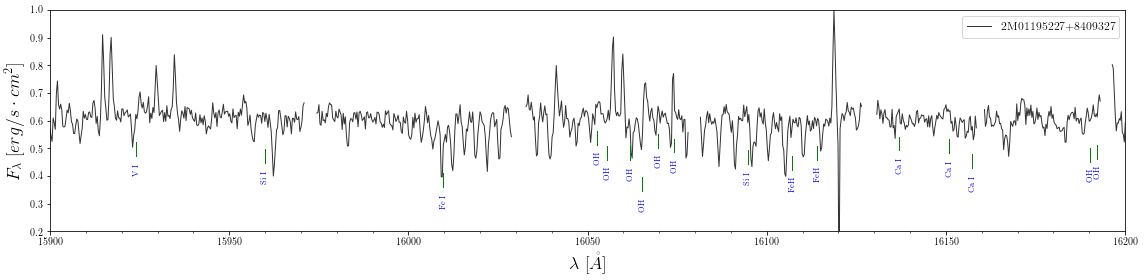

In [32]:
data = ap.Apogee(id='2M01195227+8409327', type='ap1d', visit=1)
data.mask(sigma=[.9,0.05], pixel_buffer=[0,2])
data.flux = data.flux/max(data.flux)
data.plot(items=['spec', 'noise', 'lines'], yrange=[.2, 1], xrange=[15900,16200])

/home/jess/Desktop/astro_code/apogee_tools/apogee_tools/apogee_hack/spec/lsf.py:176: RuntimeWarning: invalid value encountered in less
  out[out<0.]= 0.
/home/jess/Desktop/astro_code/apogee_tools/apogee_tools/apogee_hack/spec/lsf.py:177: RuntimeWarning: invalid value encountered in true_divide
  out/= numpy.tile(numpy.sum(out,axis=1),(len(x),1)).T



[26.999548196792603s] MCMC initialization step complete.

##################################################
Making model: teff=3100 logg=5.5 fe_h=-0.3 vsini=0.1 rv=-41 alpha=1.4
[0.03094315528869629s] Interpolated model
[0.008281707763671875s] Shifted radial velocity
[0.014339923858642578s] Applied vsini broadening
[2.949533224105835s] Convolved telluric model
[0.07825803756713867s] Applied LSF broadening 



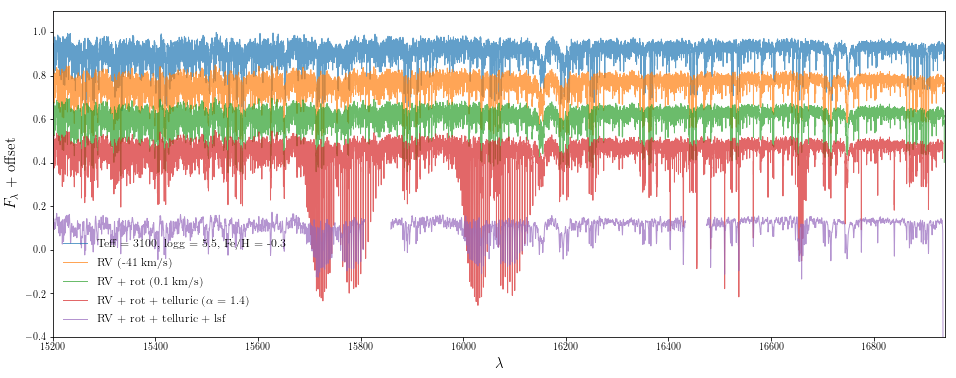

In [3]:
params = {'teff': 3100, 'logg': 5.5, 'fe_h': -0.3, 'vsini': 0.1, 'rv': -41, 'alpha': 1.4}
init_param, step_param, init_theta, step_theta, fiber, tell_sp, lsf = ap.initialize()

# mdl = ap.getModel(params=[3100, 5.5, -0.5], grid='BTSETTL', xrange=[15200,16940])
mdl = ap.makeModel(params=params, lsf=lsf, telluric=tell_sp, plot=True)

In [34]:
data.error

array([1.e+10, 1.e+10, 1.e+10, ..., 1.e+10, 1.e+10, 1.e+10], dtype=float32)

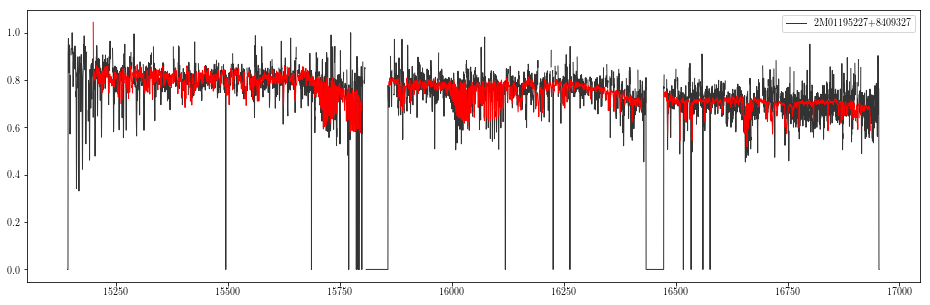

In [21]:
c = ap.continuum(data, mdl, bands=ap.data["orders"], deg=5)

fig = plt.figure(figsize=[16,5])
plt.plot(data.wave, data.flux, color='k', label=data.name, alpha=.8, linewidth=1)
plt.plot(c.wave, c.flux, color='r', linewidth=1)
plt.legend(loc='upper right')
# plt.ylim(0, .1)
plt.show()

In [41]:
chi, sp1, sp2 = compareSpectra(data, c, fit_scale=False)
chi

0.28573343282711805

array([1.00000000e+10, 1.00000000e+10, 1.00000000e+10, 1.00000000e+10,
       3.14942284e+01, 3.14215565e+01, 3.21389923e+01, 3.07788353e+01,
       3.18549366e+01, 2.96387444e+01, 3.02923355e+01, 3.08989563e+01,
       3.16312847e+01, 3.18289471e+01, 3.15839348e+01, 2.90590096e+01,
       2.55881062e+01, 2.63210392e+01, 2.95576191e+01, 2.98946266e+01,
       3.21030617e+01, 3.42434578e+01, 3.17841702e+01, 3.08076706e+01,
       3.13755608e+01, 3.13762360e+01, 3.28457375e+01, 3.36871567e+01,
       3.13446579e+01, 3.14836712e+01, 3.21698380e+01, 3.13613224e+01,
       3.13514500e+01, 3.09349918e+01, 3.08047180e+01, 3.09306393e+01,
       2.89064159e+01, 2.87746677e+01, 3.00969009e+01, 3.08062534e+01,
       3.03131027e+01, 3.04490414e+01, 3.02646732e+01, 3.01010132e+01,
       3.05279045e+01, 2.98096619e+01, 3.09924641e+01, 3.04952240e+01,
       3.09776363e+01, 3.11278629e+01, 2.95413818e+01, 3.00378323e+01,
       3.03526382e+01, 2.89831448e+01, 2.88263645e+01, 2.75036945e+01,
      

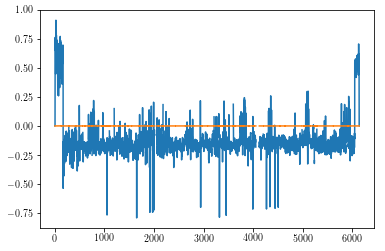

In [64]:
from scipy.interpolate import interp1d
f = interp1d(c.wave, c.flux, bounds_error=False, fill_value=0.)
flux2 = f(data.wave)
plt.plot(c.wave, c.flux)
plt.plot(data.wave, flux2)
plt.close()

flux1 = data.flux
diff = flux1 - flux2
stat = diff**2/np.array(data.error)**2
plt.plot(diff)
plt.plot(stat)
np.nansum(stat)

data.error[0:1000]

In [39]:
def compareSpectra(sp1, sp2, **kwargs):

    fit_range = kwargs.get('fit_range', [sp1.wave[0], sp1.wave[-1]])
    fit_scale = kwargs.get('fit_scale', True)
    normalize = kwargs.get('norm', True)
    ivariance = kwargs.get('ivar', False)

    from scipy.interpolate import interp1d

    #sp2 will be interpolated to the same wavelenth values as sp1
    wave1 = sp1.wave
    flux1 = sp1.flux
    if ivariance == True:
        ivar = sp1.ivar
    else:
        unc  = sp1.error

    #Interpolation function 
    f = interp1d(sp2.wave, sp2.flux, bounds_error=False, fill_value=0.)
    flux2 = f(wave1)

    #Create a new spectrum object for sp2
    sp2 = ap.Spectrum(wave=wave1, flux=flux2, param=sp2.param)

    #Compute scale factor for 2nd spectrum
    if fit_scale == True:
        scale = ap.calcScale(sp1, sp2)
    else:
        scale = 1

    #Compute chi-squared value
    flux2 = scale*flux2
    diff = flux1 - flux2
    if ivariance == True:
        stat = (diff**2)*ivar
    else:
        stat = diff**2/np.array(unc)**2
    chi = np.nansum(stat)

    sp2 = ap.Spectrum(wave=wave1, flux=flux2, param=sp2.param)

    return chi, sp1, sp2

In [163]:
out = continuum(data, mdl, deg=5)

In [164]:
len(out.wave), len(out.flux)

(6099, 6099)

[[15140, 15800], [15860, 16425], [16475, 16945]]

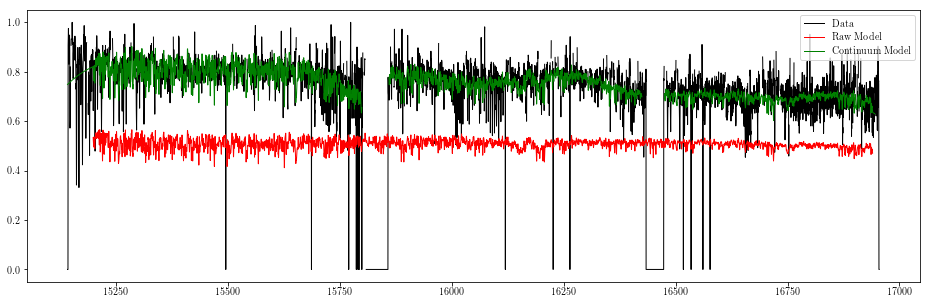

In [165]:
fig = plt.figure(figsize=[16,5])
plt.plot(data.wave, data.flux, color='k', linewidth=1, label='Data')
plt.plot(mdl.wave, mdl.flux, color='r', linewidth=1, label='Raw Model')
plt.plot(out.wave, out.flux, color='g', linewidth=1, label='Continuum Model')
plt.legend(loc='upper right')
plt.show()

In [90]:
len(out.wave)

6007

In [91]:
len(data.wave)

6144